# Predicting House Prices (Regression)

## 1) Import, Load data, Splitting

Imports

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# feature selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Regression models
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error     #for mean_squared_error and root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score               # good overall measure for linear relationships



Load data

In [102]:
# iteration 7
url = 'https://drive.google.com/file/d/1WN_JAZVHmpi_KMk4Zgyv7S3G3BekEn82/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path)

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Split X and y

In [104]:
X = data.copy()
y = X.pop('SalePrice')

Please drop the ID column before the train-test split

In [105]:
# for example Menna dropped these columns:
#X = X.drop(['Id', 'Alley','PoolQC','Fence','MiscFeature' ,'FireplaceQu'],axis=1)

In [106]:
# missing data - shows the 10 columns with the highest percentage of missing values

per = data.isna().sum()/len(data)*100
per.nlargest(10)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
dtype: float64

Split train- and testdata

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=8)

## 2) EDA and Dummy Model

In [108]:
# let's find a column that is highly correlated
data.corrwith(data['SalePrice']).sort_values(ascending=False).head()

<ipython-input-108-228cdf2e00b1>:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corrwith(data['SalePrice']).sort_values(ascending=False).head()


SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
dtype: float64

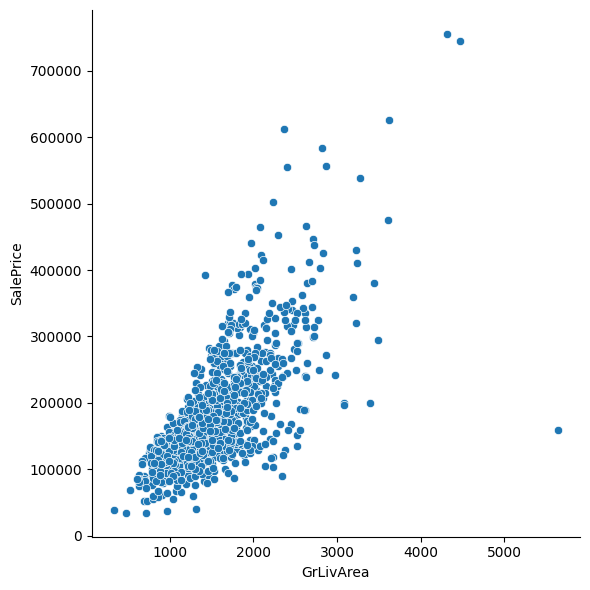

In [109]:
# plot the relationship
sns.relplot(x=X_train['GrLivArea'],y=y_train,height=6)


Conclude about a good relation

In [110]:
# GrLivArea * 100

In [111]:
# calculate the endpoint for the red line
5000 * 100

500000

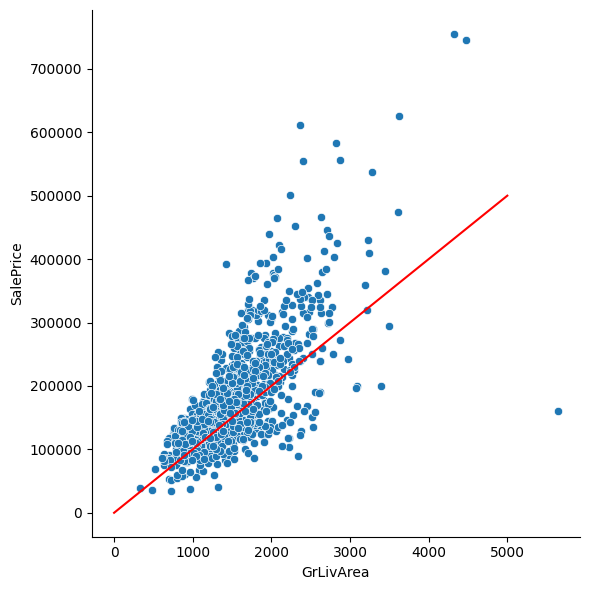

In [112]:
# plot the relationship again, this time with our dumb-model prediction line
sns.relplot(x=X_train['GrLivArea'],y=y_train,height=6)
plt.plot([0, 5000], [0, 500000], 'r-')
plt.show();

yay! Dummy model looks ok. Let's check how it performs.

In [113]:
# get the prediction for test
dummy_model_predictions = X_test['GrLivArea'] *100
dummy_model_predictions

1260    167500
274      81600
51      117600
117     112500
789     208700
         ...  
801     119600
1292    237200
197     311200
780     125300
360      91200
Name: GrLivArea, Length: 292, dtype: int64

--- with the four regression scores:

In [114]:
# Mean absolute error
dummy_mae = mean_absolute_error(y_true = y_test, y_pred = dummy_model_predictions)

# Root mean squared error
dummy_rmse = mean_squared_error(y_true = y_test, y_pred = dummy_model_predictions, squared=False)

# mean absolute percentage error
dummy_mape = mean_absolute_percentage_error(y_true = y_test, y_pred = dummy_model_predictions)

# R2
dummy_r2 = r2_score(y_true = y_test, y_pred = dummy_model_predictions)

pd.DataFrame({"MAE": [dummy_mae],
              "RMSE": [dummy_rmse],
              "MAPE": [dummy_mape],
              "R2": [dummy_r2]},
             index=["dummy_model"])

,MAE,RMSE,MAPE,R2
dummy_model,45132.941781,62374.879403,0.232026,0.260654


- The Mean absolute Error tells us, that our estimates are on average 45.000 EUR off

- And the Root mean squared error is higher than Mean absolute Error, so it tells us that we have outliers that contribute more to this value.

- The Mean Percentage Error tells us, that we are on average 23% wrong

- And the R2 value tells us that 26% of the variance of the data can be explained with our prediction.


## 3) Preprocessing

In [115]:
X_cat = X_train.select_dtypes(exclude="number").copy()
X_num = X_train.select_dtypes(include="number").copy()

### Numeric pipe

In [116]:
numerical_pipe = make_pipeline(SimpleImputer())

### Ordinal pipe (OPTIONAL)

In [117]:
# Column index for ordinal encoded columns - we need this later
ordinal_columns = X.columns.get_indexer(["LotShape", "Utilities", "LandSlope"])

# ---

# Order of values for each column in a list
LotShape_cats = ["Reg", "IR1", "IR2", "IR3"]
Utilities_cats = ["AllPub", "NoSewr", "NoSeWa", "ELO"]
LandSlope_cats = ["Gtl", "Mod", "Sev"]

# List of lists for each column
ordinal_cats = [LotShape_cats, Utilities_cats, LandSlope_cats]

# initialize the OrdinalEncoder with list of columns and their ordered categories
ordinal_encoder = OrdinalEncoder(categories=ordinal_cats)

In [118]:
# create an ordinal_Pipeline
ordinal_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="N_A"),
                                 ordinal_encoder)

### OneHotEncoding pipe

In [119]:
# remaining categorical columns need to go to OneHotEncoding - we will need this later
list_of_categorical_column_names_for_OHE = list(set(X_cat) - set(ordinal_columns))
ohe_columns = X.columns.get_indexer(list_of_categorical_column_names_for_OHE)

In [120]:
# initialize OneHotEncoder
ohe_encoder = OneHotEncoder(handle_unknown="ignore")

In [121]:
# create a OHE_pipeline
ohe_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="N_A"),
                                 ohe_encoder)

### All pipes together

In [122]:
# Final preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numerical_pipe, X_num.columns),
        ("ordinal_pipe", ordinal_pipe, ordinal_columns),
        ("one_hot_pipe", ohe_pipe, ohe_columns),
    ]
)

## 4) Model with pipeline and Search

### DecisionTreeRegressor

Which feature selection method can we put where:
- VarianceThreshold() - can be used inside the pipe (see below)
  - you can also explore the variance further up before preprocessing
- Multicollinearity - (if the features are correlated) you'd use this before the preprocessing

**--> If you drop one columns from X_train (before the pipeline / before the prerpocessor) then you also have to drop this column from X_test before using it.**


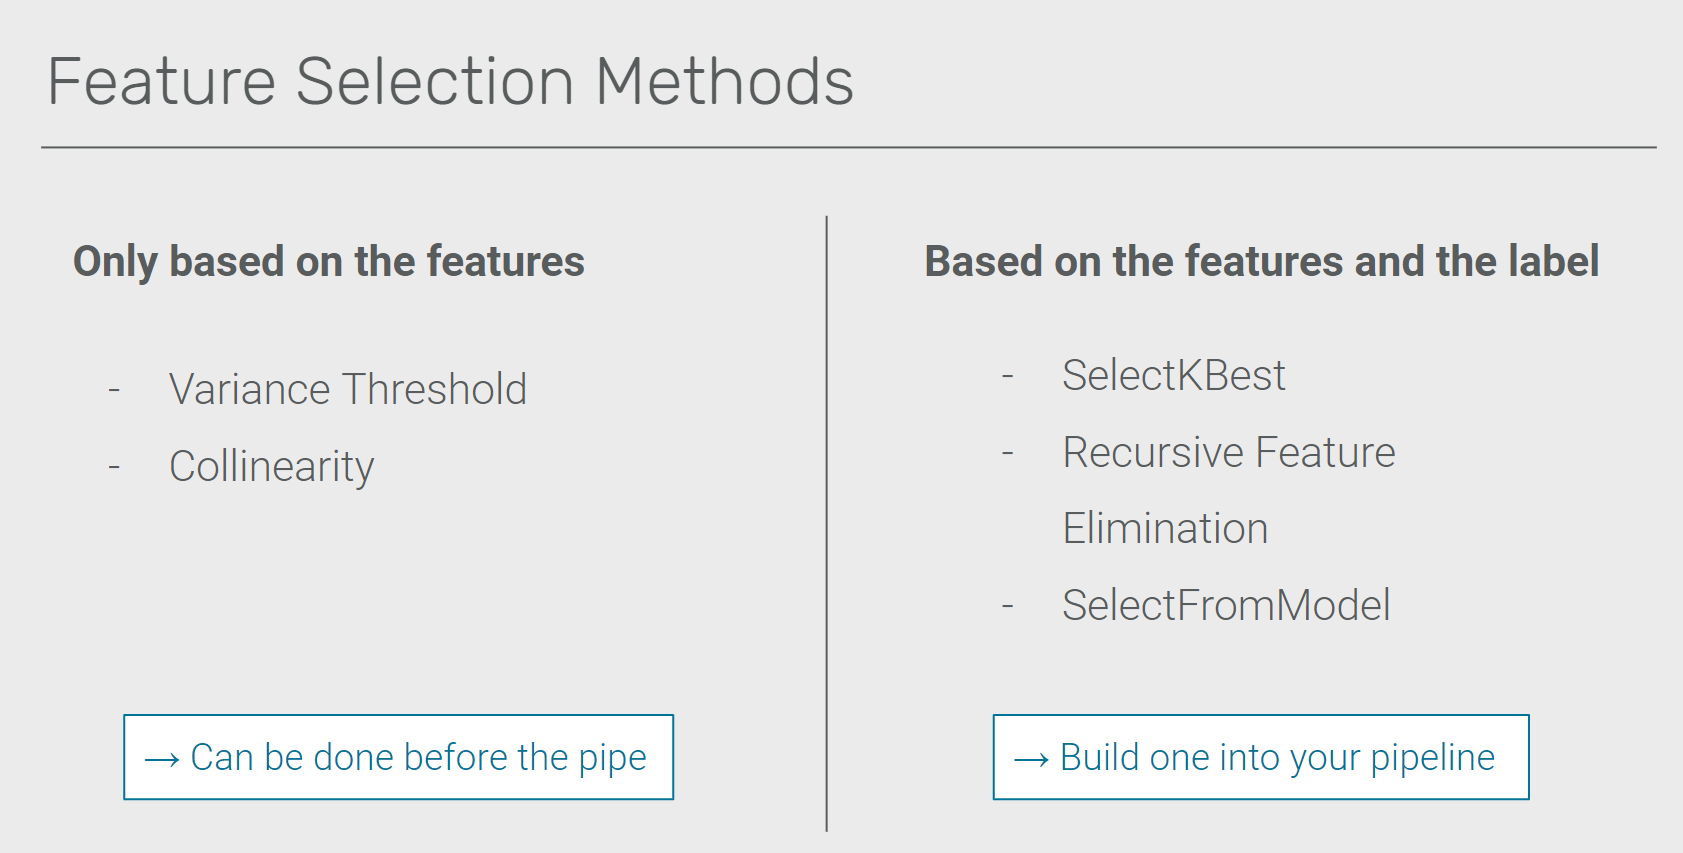

In [123]:
dt_pipeline = make_pipeline(preprocessor,
                            MinMaxScaler(),
                            VarianceThreshold(),
                            SelectKBest(score_func=f_regression),
                            DecisionTreeRegressor())

dt_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea'...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  array([22, 15, 16, 40, 23, 78, 31, 32, 39, 60, 65, 57, 25,  7,  6, 21, 73,
        2, 33, 41, 24, 13, 12, 35, 55, 58, 27, 28, 10, 30, 42, 63, 79,  9,
       64, 11, 14, 72,  5, 29, 53,  8, 74]))])),
                ('minmaxscaler', MinMaxScaler()),
                ('variancethreshold', VarianceThreshold()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x787bad235ea0>)),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [124]:
# **To put everything into a searchCV**
# - create a paramgrid
param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median", "constant"],
    "selectkbest__k": range(5, 85, 5),
    "decisiontreeregressor__max_depth": range(2, 14),
    "decisiontreeregressor__min_samples_leaf": range(2, 12),
    "decisiontreeregressor__criterion":["squared_error", "absolute_error", "poisson"],

}

# - create the search (RandomizedSearchCV or GridSearchCV)
dt_search = RandomizedSearchCV(dt_pipeline,     # pipeline that contains the preprocessor and Tree
                              param_grid,       # parameter for search
                              cv=5,             # number of folds
                              n_iter = 50,      # number of different combinations of parameters from paramgrid
                              scoring='neg_root_mean_squared_error',   # how to measure the best performance
                              verbose=1)        # text output




In [125]:
# - search.fit()
dt_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


ValueError: ignored

In [ ]:
dt_search.best_params_

In [ ]:
# pd.DataFrame(dt_search.best_estimator_.named_steps['decisiontreeregressor'].feature_importances_)

### Evaluate performance on Test

In [ ]:
# - search.predict(X_test)
dt_predictions = dt_search.predict(X_test)


In [ ]:
# Evaluate the performance
dt_mae = mean_absolute_error(y_true = y_test, y_pred = dt_predictions)
dt_rmse = mean_squared_error(y_true = y_test, y_pred = dt_predictions, squared=False)
dt_mape = mean_absolute_percentage_error(y_true = y_test, y_pred = dt_predictions)
dt_r2 = r2_score(y_true = y_test, y_pred = dt_predictions)

In [ ]:
# Creating a Dataframe with all results
results = pd.DataFrame({"MAE": [dummy_mae, dt_mae],
              "RMSE": [dummy_rmse, dt_rmse],
              "MAPE": [dummy_mape, dt_mape],
              "R2": [dummy_r2, dt_r2]},
             index=["dummy_model", "decision_tree"])
results

In [ ]:
results.plot.bar(subplots=True,
                             figsize=(4, 8));